<a href="https://colab.research.google.com/github/sunin1104/Repository/blob/main/0619.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

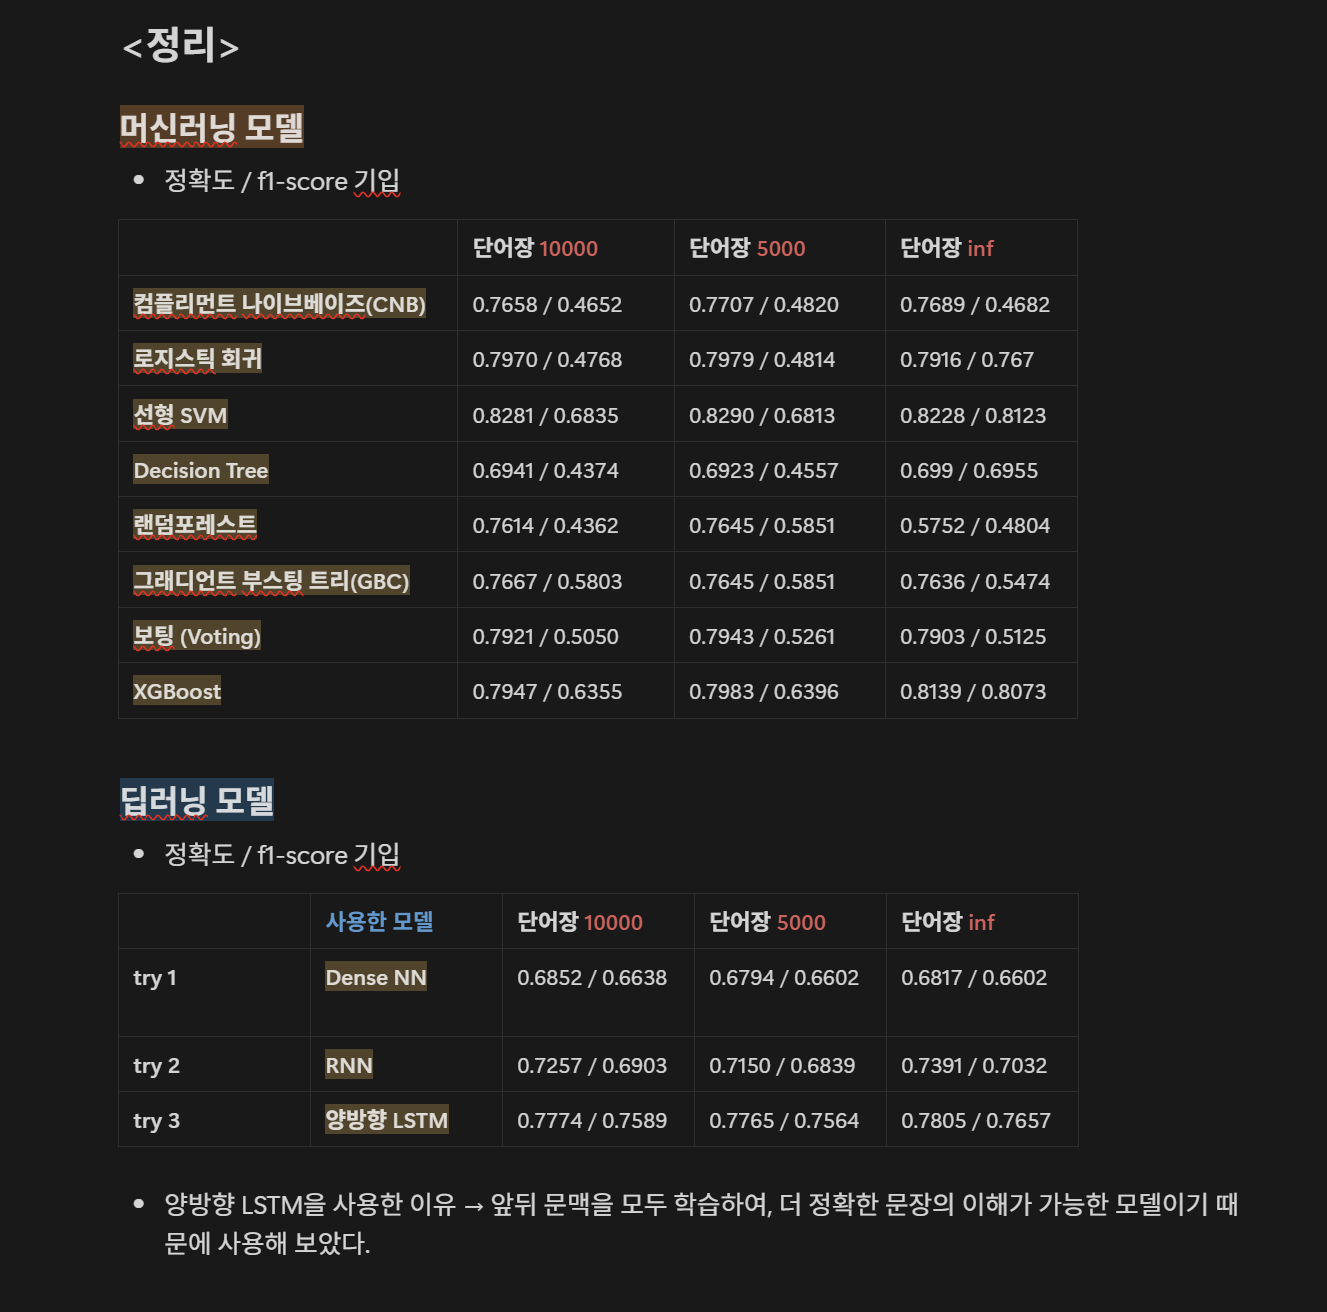

In [29]:
import tensorflow
import matplotlib
import seaborn
import numpy
import pandas
import sklearn

print(tensorflow.__version__)
print(matplotlib.__version__)
print(seaborn.__version__)
print(numpy.__version__)
print(pandas.__version__)
print(sklearn.__version__)

2.18.0
3.10.0
0.13.2
1.26.4
2.2.2
1.6.1


## TF-IDF로 벡터화 + 7가지 머신러닝 모델(M1~M7)로 성능 비교

In [30]:
from tensorflow.keras.datasets import reuters
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score

In [44]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2)


숫자로 된 기사 → 단어로 복원

In [45]:
word_index = reuters.get_word_index()
index_word = {v + 3: k for k, v in word_index.items()}
index_word[0], index_word[1], index_word[2], index_word[3] = "<PAD>", "<START>", "<UNK>", "<UNUSED>"

In [46]:
def decode_review(encoded):
    return ' '.join(index_word.get(i, '?') for i in encoded)


In [47]:
x_train_text = [decode_review(seq) for seq in x_train]
x_test_text = [decode_review(seq) for seq in x_test]

TF-IDF 벡터화

In [48]:
vectorizer = TfidfVectorizer(max_features=5000)
x_train_vec = vectorizer.fit_transform(x_train_text)
x_test_vec = vectorizer.transform(x_test_text)

모델 정의

In [49]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score

# XGBoost 모델 정의
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# 학습
model.fit(x_train_vec, y_train)

# 예측
preds = model.predict(x_test_vec)

# 평가
acc = accuracy_score(y_test, preds)
f1 = f1_score(y_test, preds, average='macro')

print(f"XGBoost Accuracy: {acc:.4f}")
print(f"XGBoost F1-score: {f1:.4f}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:52:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.7947
XGBoost F1-score: 0.6355


In [50]:
models = {
    "CNB": ComplementNB(),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "LinearSVM": LinearSVC(),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(),
    "GradientBoosting": GradientBoostingClassifier(),
    "Voting": VotingClassifier(
        estimators=[
            ('lr', LogisticRegression(max_iter=1000)),
            ('rf', RandomForestClassifier()),
            ('gbt', GradientBoostingClassifier())
        ],
        voting='hard'
    )
}

In [51]:
from sklearn.metrics import accuracy_score, f1_score

results = {}

for name, model in models.items():
    model.fit(x_train_vec, y_train)
    preds = model.predict(x_test_vec)

    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='macro')  # 다중 클래스용 F1-score

    results[name] = {'Accuracy': acc, 'F1_score': f1}
    print(f"{name}: Accuracy={acc:.4f}, F1-score={f1:.4f}")

RandomForest: Accuracy=0.7596, F1-score=0.4362


In [ ]:
import pandas as pd

# DataFrame 생성 (모델명이 인덱스)
df_results = pd.DataFrame(results).T

# 소수점 4자리로 반올림
df_results = df_results.round(4)

# 가로 출력 (모델명이 컬럼, 평가 지표가 행)
print(df_results.T)

             CNB  LogisticRegression  LinearSVM  DecisionTree  RandomForest  \
Accuracy  0.7707              0.7979     0.8290        0.6923        0.7645   
F1_score  0.4820              0.4814     0.6813        0.4557        0.4348   

          GradientBoosting  Voting  
Accuracy            0.7645  0.7943  
F1_score            0.5851  0.5261  


## 1 실험  
## voca 10,000
       CNB        LogisticRegression  LinearSVM  DecisionTree  RandomForest
Accuracy  0.7658        0.7970          0.8281        0.6941        0.7614

F1_score  0.4652        0.4768          0.6835        0.4374        0.43   
            
             GradientBoosting         Voting
Accuracy            0.7667            0.7921

F1_score            0.5803            0.5050


## voca none
         CNB     LogisticRegression  LinearSVM   DecisionTree   RandomForest
Accuracy  0.7689       0.7988          0.8264       0.6999        0.7667

F1_score  0.4682       0.4750          0.6770       0.4435        0.4626  
            
             GradientBoosting         Voting
Accuracy            0.7667            0.7921

F1_score            0.5803            0.5050

## voca 5000
         CNB  LogisticRegression  LinearSVM  DecisionTree  RandomForest
Accuracy  0.7707              0.7979     0.8290        0.6923        0.7645

F1_score  0.4820              0.4814     0.6813        0.4557        0.4348

                GradientBoosting  Voting
Accuracy             0.7645       0.7943

F1_score             0.5851       0.5261


In [ ]:
data = {
    'Accuracy@5000': {
        'CNB': 0.7707,
        'LogisticRegression': 0.7979,
        'LinearSVM': 0.8290,
        'DecisionTree': 0.6923,
        'RandomForest': 0.7645,
        'GradientBoosting': 0.7645,
        'Voting': 0.7943,
    },
    'F1-score@5000': {
        'CNB': 0.4820,
        'LogisticRegression': 0.4814,
        'LinearSVM': 0.6813,
        'DecisionTree': 0.4557,
        'RandomForest': 0.4348,
        'GradientBoosting': 0.5851,
        'Voting': 0.5261,
    },
    'Accuracy@10000': {
        'CNB': 0.7658,
        'LogisticRegression': 0.7970,
        'LinearSVM': 0.8281,
        'DecisionTree': 0.6941,
        'RandomForest': 0.7614,
        'GradientBoosting': 0.7667,
        'Voting': 0.7921,
    },
    'F1-score@10000': {
        'CNB': 0.4652,
        'LogisticRegression': 0.4768,
        'LinearSVM': 0.6835,
        'DecisionTree': 0.4374,
        'RandomForest': 0.4300,
        'GradientBoosting': 0.5803,
        'Voting': 0.5050,
    },
    'Accuracy@All': {
        'CNB': 0.7689,
        'LogisticRegression': 0.7988,
        'LinearSVM': 0.8264,
        'DecisionTree': 0.6999,
        'RandomForest': 0.7667,
        'GradientBoosting': 0.7636,
        'Voting': 0.7903,
    },
    'F1-score@All': {
        'CNB': 0.4682,
        'LogisticRegression': 0.4750,
        'LinearSVM': 0.6770,
        'DecisionTree': 0.4435,
        'RandomForest': 0.4626,
        'GradientBoosting': 0.5474,
        'Voting': 0.5125,
    },
}

# DataFrame 생성
df_results = pd.DataFrame(data)

# 보기 좋게 출력
print(df_results.round(4))

                    Accuracy@5000  F1-score@5000  Accuracy@10000  \
CNB                        0.7707         0.4820          0.7658   
LogisticRegression         0.7979         0.4814          0.7970   
LinearSVM                  0.8290         0.6813          0.8281   
DecisionTree               0.6923         0.4557          0.6941   
RandomForest               0.7645         0.4348          0.7614   
GradientBoosting           0.7645         0.5851          0.7667   
Voting                     0.7943         0.5261          0.7921   

                    F1-score@10000  Accuracy@All  F1-score@All  
CNB                         0.4652        0.7689        0.4682  
LogisticRegression          0.4768        0.7988        0.4750  
LinearSVM                   0.6835        0.8264        0.6770  
DecisionTree                0.4374        0.6999        0.4435  
RandomForest                0.4300        0.7667        0.4626  
GradientBoosting            0.5803        0.7636        0.5474  


# 2번째 실험

In [1]:
!pip install gensim

In [2]:
from tensorflow.keras.datasets import reuters
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec

(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)
word_index = reuters.get_word_index()
index_word = {v + 3: k for k, v in word_index.items()}
index_word[0], index_word[1], index_word[2] = "<PAD>", "<START>", "<UNK>"

x_train_text = [['<START>'] + [index_word.get(i, '?') for i in seq] for seq in x_train]
x_test_text = [['<START>'] + [index_word.get(i, '?') for i in seq] for seq in x_test]

2110848/2110848 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
550378/550378 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
import numpy as np
w2v_model = Word2Vec(sentences=x_train_text, vector_size=100, window=5, min_count=1, workers=4)
embedding_matrix = np.zeros((len(w2v_model.wv), 100))
word_to_index = {word: idx for idx, word in enumerate(w2v_model.wv.index_to_key)}
for word, idx in word_to_index.items():
    embedding_matrix[idx] = w2v_model.wv[word]

In [4]:
def text_to_w2v_index(seq):
    return [word_to_index.get(word, 0) for word in seq]

x_train_idx = [text_to_w2v_index(seq) for seq in x_train_text]
x_test_idx = [text_to_w2v_index(seq) for seq in x_test_text]

# 패딩
x_train_pad = pad_sequences(x_train_idx, maxlen=100)
x_test_pad = pad_sequences(x_test_idx, maxlen=100)

## Word2Vec + LSTM

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

model = Sequential([
    Embedding(input_dim=len(w2v_model.wv), output_dim=100, weights=[embedding_matrix], input_length=100, trainable=False),
    LSTM(128),
    Dense(46, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     2,813,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,813,800 (10.73 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,813,800 (10.73 MB)

In [6]:
model.fit(x_train_pad, y_train, epochs=10, batch_size=64, validation_split=0.2)

# 예측 및 평가
from sklearn.metrics import accuracy_score, f1_score

y_pred = model.predict(x_test_pad).argmax(axis=1)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Word2Vec + LSTM -> Accuracy: {acc:.4f}, F1-score: {f1:.4f}")

Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 308ms/step - accuracy: 0.4441 - loss: 2.2714 - val_accuracy: 0.6127 - val_loss: 1.5686
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 31s 226ms/step - accuracy: 0.6244 - loss: 1.5139 - val_accuracy: 0.6555 - val_loss: 1.4373
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 225ms/step - accuracy: 0.6591 - loss: 1.3347 - val_accuracy: 0.6722 - val_loss: 1.2923
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 42s 237ms/step - accuracy: 0.6919 - loss: 1.2187 - val_accuracy: 0.6989 - val_loss: 1.2173
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 40s 226ms/step - accuracy: 0.7049 - loss: 1.1511 - val_accuracy: 0.7184 - val_loss: 1.1736
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 40s 220ms/step - accuracy: 0.7315 - loss: 1.0375 - val_accuracy: 0.7245 - val_loss: 1.1472
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 39s 207ms/step - accuracy: 0.7403 - loss: 0.9986 - val_accuracy: 0.7340 - val_loss: 1.1183
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 42s 220ms/step - accuracy: 0.7630 - loss: 0

## Word2Vec + Simple RNN

In [7]:

lengths = [len(seq) for seq in x_train_idx]
print(f"최소 길이: {min(lengths)}")
print(f"최대 길이: {max(lengths)}")
print(f"평균 길이: {np.mean(lengths):.2f}")

# 90% 데이터가 포함되는 길이
max_len_90 = int(np.percentile(lengths, 90))
print(f"90% 데이터가 포함되는 시퀀스 길이: {max_len_90}")

최소 길이: 14
최대 길이: 2377
평균 길이: 146.54
90% 데이터가 포함되는 시퀀스 길이: 314


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# 시퀀스 패딩
max_len = 314
x_train_pad = pad_sequences(x_train_idx, maxlen=max_len, padding='post')
x_test_pad = pad_sequences(x_test_idx, maxlen=max_len, padding='post')

# 모델 정의
model = Sequential()
model.add(Embedding(input_dim=len(w2v_model.wv),
                    output_dim=w2v_model.vector_size,
                    weights=[embedding_matrix],
                    input_length=max_len,
                    trainable=True))
model.add(SimpleRNN(128))
model.add(Dense(46, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 학습
model.fit(x_train_pad, y_train, epochs=10, batch_size=64, validation_split=0.2)

# 예측
y_pred = model.predict(x_test_pad)
y_pred_labels = np.argmax(y_pred, axis=1)

# 평가
acc = accuracy_score(y_test, y_pred_labels)
f1 = f1_score(y_test, y_pred_labels, average='weighted')

print(f"Rnn Accuracy: {acc:.4f}")
print(f"Rnn F1-score: {f1:.4f}")

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 218ms/step - accuracy: 0.3330 - loss: 2.6675 - val_accuracy: 0.3550 - val_loss: 2.3855
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 40s 208ms/step - accuracy: 0.3715 - loss: 2.3848 - val_accuracy: 0.3589 - val_loss: 2.3843
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 24s 213ms/step - accuracy: 0.3681 - loss: 2.3780 - val_accuracy: 0.3567 - val_loss: 2.3790
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 213ms/step - accuracy: 0.3645 - loss: 2.3771 - val_accuracy: 0.3567 - val_loss: 2.3795
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 24s 215ms/step - accuracy: 0.3974 - loss: 2.3057 - val_accuracy: 0.3595 - val_loss: 2.3801
Epoch 6/10


 ## Word2Vec + Dense (완전 연결층)

In [85]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Flatten, Dense

# 모델 정의
model = Sequential()
model.add(Embedding(input_dim=len(w2v_model.wv),
                    output_dim=w2v_model.vector_size,
                    weights=[embedding_matrix],
                    input_length=max_len,
                    trainable=True))
model.add(Flatten())  # 시퀀스를 일렬로 펼치기
model.add(Dense(128, activation='relu'))
model.add(Dense(46, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 학습
model.fit(x_train_pad, y_train, epochs=10, batch_size=64, validation_split=0.2)

# 예측
y_pred = model.predict(x_test_pad)
y_pred_labels = np.argmax(y_pred, axis=1)

# 평가
acc = accuracy_score(y_test, y_pred_labels)
f1 = f1_score(y_test, y_pred_labels, average='weighted')

print(f"DenseNN Accuracy: {acc:.4f}")
print(f"DenseNN F1-score: {f1:.4f}")

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.5044 - loss: 3.3689 - val_accuracy: 0.6650 - val_loss: 1.4517
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7923 - loss: 0.8259 - val_accuracy: 0.6834 - val_loss: 1.4247
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8831 - loss: 0.5013 - val_accuracy: 0.6694 - val_loss: 1.5169
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9358 - loss: 0.3308 - val_accuracy: 0.6717 - val_loss: 1.5560
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9528 - loss: 0.2326 - val_accuracy: 0.6678 - val_loss: 1.7382
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9618 - loss: 0.1816 - val_accuracy: 0.6767 - val_loss: 1.6620
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9682 - loss: 0.1530 - val_accuracy: 0.6772 - val_loss: 1.7508
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9676 - loss: 0.1706 - val_accuracy: 0.6745 - val

## 양방향 LSTM 모델

In [86]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from sklearn.metrics import accuracy_score, f1_score

# 모델 정의
model = Sequential([
    Embedding(input_dim=len(w2v_model.wv),
              output_dim=100,
              weights=[embedding_matrix],
              input_length=max_len,
              trainable=False),
    Bidirectional(LSTM(128)),
    Dense(46, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 모델 학습
model.fit(x_train_pad, y_train, epochs=10, batch_size=64, validation_split=0.2)

# 테스트 데이터 예측
y_pred_prob = model.predict(x_test_pad)
y_pred = y_pred_prob.argmax(axis=1)

# 정확도 계산
acc = accuracy_score(y_test, y_pred)

# F1-score 계산 (다중 클래스, macro 평균)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Test Accuracy: {acc:.4f}")
print(f"Test F1-score: {f1:.4f}")

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.5024 - loss: 2.0682 - val_accuracy: 0.6784 - val_loss: 1.3720
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.6965 - loss: 1.2732 - val_accuracy: 0.7279 - val_loss: 1.1631
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7324 - loss: 1.0978 - val_accuracy: 0.7440 - val_loss: 1.0929
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7527 - loss: 1.0071 - val_accuracy: 0.7518 - val_loss: 1.0673
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.7666 - loss: 0.9487 - val_accuracy: 0.7329 - val_loss: 1.0911
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.7770 - loss: 0.9045 - val_accuracy: 0.7568 - val_loss: 1.0167
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7938 - loss: 0.8274 - val_accuracy: 0.7546 - val_loss: 0.9924
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.8179 - loss: 0.7471 - val_accuracy: 0.764